# INITIALISATION

In [1]:
# Third-party packages
import matplotlib.pyplot as plt
import openslide as oslide
from pathlib import Path
import h5py
import cv2
import os

from skimage import data, color
from skimage.filters import sobel, median
from skimage.transform import hough_ellipse
from skimage.feature import canny
from skimage.draw import ellipse_perimeter, ellipse
from skimage.util import img_as_ubyte
from skimage.morphology import thin, closing, opening

# Multiple read-only access to HDFS
os.environ['H5PY_DEFAULT_READONLY'] = '1'

In [2]:
# Import custom scripts as modules
import sys
from pathlib import Path
module_path = Path('.').resolve().parent
if str(module_path) not in sys.path:
    sys.path.append(str(module_path))

In [3]:
# Custom packages
from src.datagens import CamelyonDataSource
from src.datagens import WSIDatagen
from src.datagens import SimpleAugmenter
from src.config import RAW_DIR

In [5]:
# Prepare generator

SLIDE_DIR = RAW_DIR / 'Camelyon16' / 'slides'

# Prepare config
import json
with (Path('.').resolve().parent / 'configs' / 'wsi.json').open('r') as json_in:
    params = json.load(json_in)
params['data']['meta']['level'] = 1
params['data']['meta']['context_size'] = 1
params['data']['meta']['tile_size'] = 256
params['data']['dataset'] = '/mnt/data/crc_ml/data/processed/Camelyon16/level0/r256px/c192px/t256px/all/datasets/1576147979.h5'
params['model']['input_shape'] = (256,256)
params['batch_size'] = 10

# Create datasource
ds = CamelyonDataSource()
ds.add_dataset(params['data']['dataset'], 'train')

# Create data generator
dg = WSIDatagen(params, slide_dir=SLIDE_DIR)

# Get image generator
gen = dg.get_sequential_generator(datasource=ds)

In [6]:
# Display multiple images side by side
def show_images(imgs, titles=None, grayscale=None):
    num_imgs = len(imgs)
    cols = min([num_imgs, 4])
    rows = max([1, -(-num_imgs // 4)])
    dpi = 6
    
    fig = plt.figure(figsize=(dpi*cols, dpi*rows))
    
    for im_idx in range(num_imgs):        
        ax = fig.add_subplot(rows, cols, im_idx+1, xticks=[], yticks=[])
        
        if titles:
            ax.set_title(titles[im_idx])
        
        if grayscale:
            plt.imshow(imgs[im_idx], cmap=grayscale[im_idx])
        else:
            plt.imshow(imgs[im_idx])

# LEARNING HSD TRANSFORMATION FOR A SINGLE SLIDE

In [7]:
# Get slide names for tiles in batch
slides = list(set([e[0] for e in gen.coords[:]]))
print(slides)

['tumor_037']


## Trying conversion

In [8]:
# Use different sampling level
gen.tile_extractor.level = 1

In [9]:
# Shuffle for variety
np.random.shuffle(gen.coords)

In [18]:
# Retrieve batch
X, y = gen.unaugmented(1)

# Rescale back to 0-255 range
tumor_tiles = ((X+1)*127.5).astype(np.int)

(256, 256, 3)


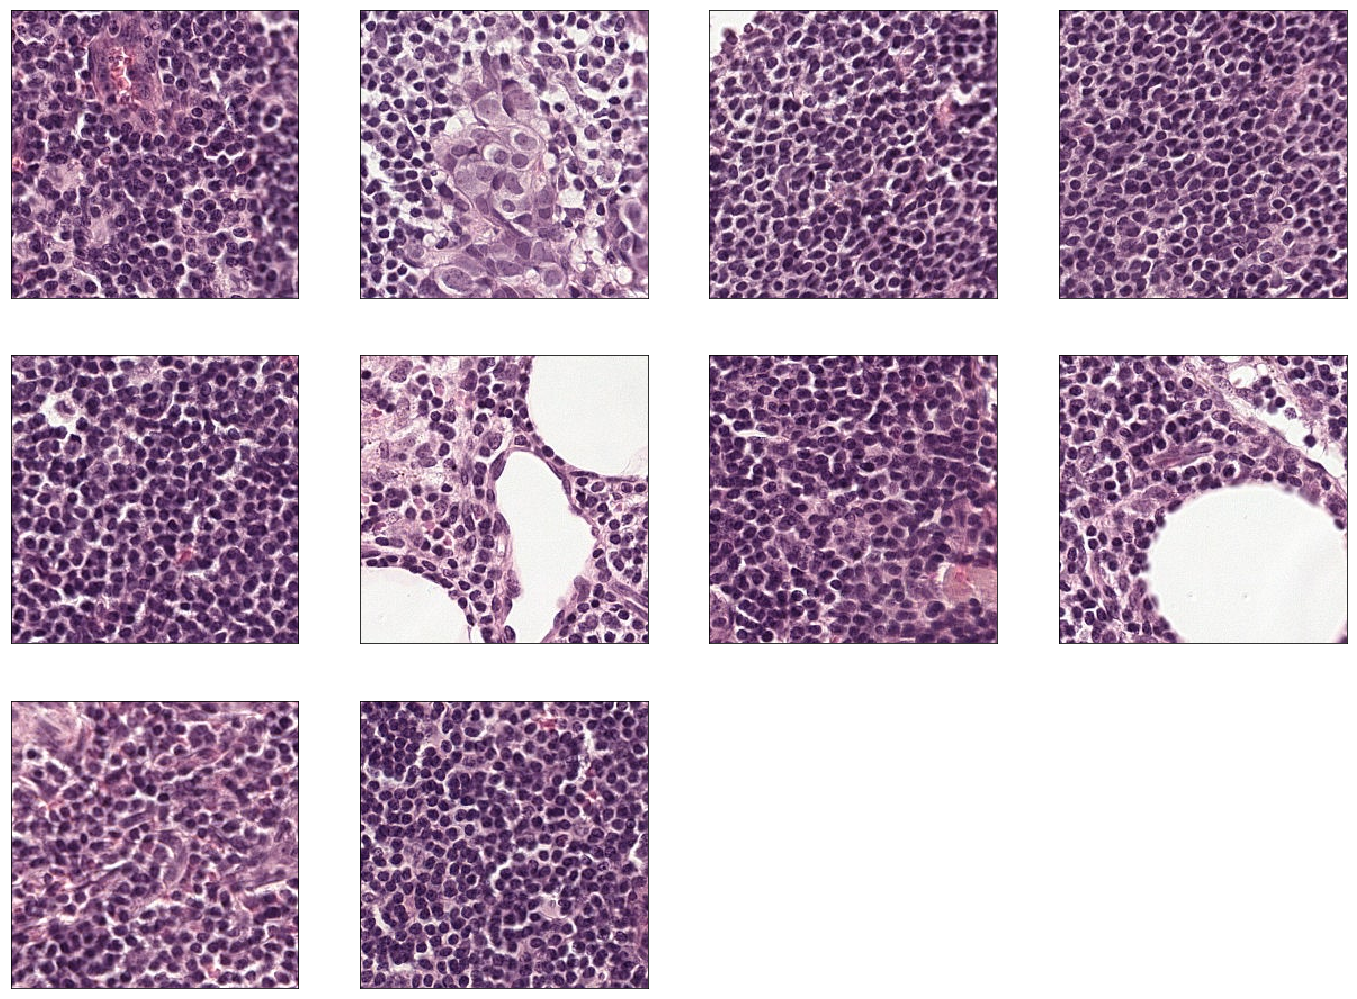

In [19]:
# Pick a tile from the batch
tumor_tile = tumor_tiles[0]
print(tumor_tile.shape)
show_images(tumor_tiles)

In [20]:
# Convert tile from RGB to HSD

# Optical densities
img_d = -np.log((tumor_tile + 1) / 257)

# Overall density
D = (img_d[:,:,0] + img_d[:,:,1] + img_d[:,:,2])
cx = (img_d[:,:,0] / D)-1
cy = (img_d[:,:,1] - img_d[:,:,2])/(np.sqrt(3)*D)

# Convert to HSD
Cmax = np.max(img_d, axis=2)
Cmin = np.min(img_d, axis=2)
delta = Cmax - Cmin

# Hue Calculation
img_d[:,:,0] = img_d[:,:,0]/np.max(img_d[:,:,0])
img_d[:,:,1] = img_d[:,:,1]/np.max(img_d[:,:,1])
img_d[:,:,2] = img_d[:,:,2]/np.max(img_d[:,:,2])
H = np.argmax(img_d, axis=2).astype('float32')
idx0 = np.where(H == 0)
idx1 = np.where(H == 1)
idx2 = np.where(H == 2)
H[idx0] = (((img_d[:,:,1][idx0]-img_d[:,:,2][idx0])/delta[idx0]) % 6).reshape((-1)) # Cmax = R
H[idx1] = (((img_d[:,:,2][idx1]-img_d[:,:,0][idx1])/delta[idx1]) + 2).reshape((-1)) # Cmax = G
H[idx2] = (((img_d[:,:,0][idx2]-img_d[:,:,1][idx2])/delta[idx2]) + 4).reshape((-1)) # Cmax = B
H = H * 60

# Saturation Calculation
S = delta / Cmax

# Putting it all together
hsd = np.stack([H,S,D], 2)

# Image preprocessing

In [49]:
np.min(hsd[:,:,2])

0.01953909870799779

In [50]:
np.max(hsd[:,:,2])

9.627931600970616

In [48]:
np.median(hsd[:,:,2])

2.504689918928172

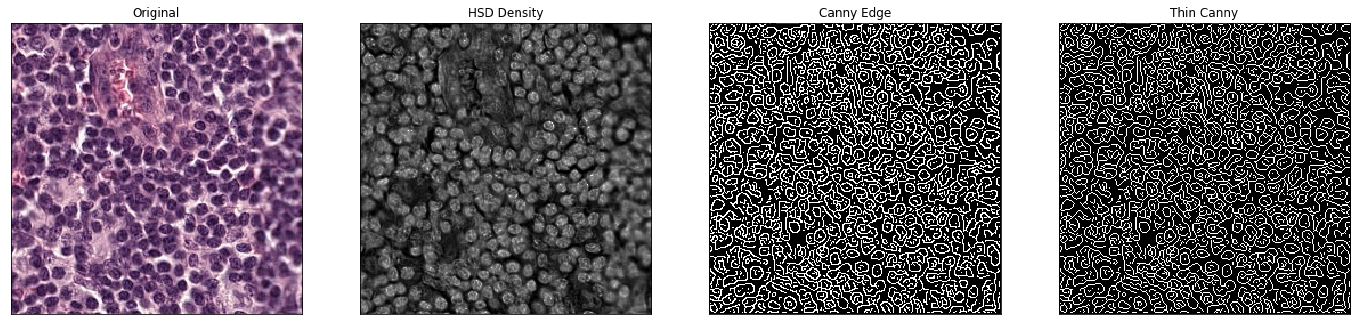

In [52]:
# Canny edge detection
edges = canny(hsd[:,:,2], low_threshold=0.5, high_threshold=2.5/2)
thin_canny_im = thin(edges)

show_images([tumor_tile, hsd[:,:,2], edges, thin_canny_im],['Original', 'HSD Density', 'Canny Edge', 'Thin Canny'], grayscale=[None, 'gray', 'gray', 'gray'])

# Image to Graph transform

In [53]:
class PixelNode:
    nodes = {}
    equivalent = {}
    next_curve_id = 1
    
    def reset_index():
        eqs = {k:min(v) for k,v in PixelNode.equivalent.items()}
        keys = sorted(list(set(eqs.values())))
        eqs = {k:keys.index(v)+1 for k,v in eqs.items()}
        for node in PixelNode.nodes.values():
            node.curve_id = eqs[node.curve_id]
        PixelNode.equivalent = eqs
    
    def __init__(self, x, y):
        self.node_id = x*1000 + y
        self.curve_id = None
        self.pos = (x,y)
        self.linklist = []
        self.type = 0
        #print('[{node_id}] at {pos}'.format(node_id=self.node_id, pos=self.pos))
        
        self.set_neighbors()
        self.set_curve_id()
        
        PixelNode.nodes[self.node_id] = self
        
    def set_curve_id(self):
        cids = [q.curve_id for q in self.linklist]
        #print('[{node_id}] Curve ids in the neighbourhood: {cids}'.format(node_id=self.node_id, cids=cids))
        
        if not cids:
            # New Graph
            self.curve_id = self.new_curve()
            #print('[{node_id}] New curve_id:{cid} created.'.format(node_id=self.node_id, cid=self.curve_id))
        elif len(set(cids)) == 1:
            # Continuation
            self.curve_id = cids[0]
            #print('[{node_id}] Adopting neighbor\'s curve_id:{cid}'.format(node_id=self.node_id, cid=self.curve_id))
        else:
            self.curve_id = cids[0]
            self.merge_curve_ids(list(set(cids)))
            #print('[{node_id}] Adopting neighbor\'s curve_id:{cid}'.format(node_id=self.node_id, cid=self.curve_id))
            #print('[{node_id}] Merging curve_ids:{cids}'.format(node_id=self.node_id, cids=cids))
    
    def new_curve(self):
        new_curve_id = PixelNode.next_curve_id
        PixelNode.equivalent[new_curve_id] = set([new_curve_id])
        PixelNode.next_curve_id += 1
        return new_curve_id
    
    def merge_curve_ids(self, cids):
        new_eq_set = None
        for cid in cids:
            if not new_eq_set:
                new_eq_set = PixelNode.equivalent[cid]
            new_eq_set.update(PixelNode.equivalent[cid])
            PixelNode.equivalent[cid] = new_eq_set
            
    def set_neighbors(self):
        for dx, dy in [(-1,-1), (0,-1), (1,-1), (-1,0)]:
            other_node_id = (self.pos[0] + dx)*1000 + (self.pos[1] + dy)
            if other_node_id in PixelNode.nodes:
                #print('[{node_id}] Node:{onode_id} found in neighbourhood.'.format(node_id=self.node_id, onode_id=other_node_id))
                # Retrieve neighbor
                other_node = PixelNode.nodes[other_node_id]
                
                # Set neighbour
                self.linklist.append(other_node)
                self.type += 1
                
                # Increase type
                other_node.linklist.append(self)
                other_node.type += 1

In [54]:
# Convert detected edges into graphs
im = thin_canny_im
for y in range(im.shape[1]):
    for x in range(im.shape[0]):
        if im[x][y]:
            PixelNode(x,y)
            
# Remove gaps from indices and replace merged sets with single number
PixelNode.reset_index()

# Count ellipses
num_ellipses = len(set(PixelNode.equivalent.values()))
print('There are {} candidate nuclei.'.format(num_ellipses))

There are 989 candidate nuclei.


# RANDOMIZED HOUGH TRANSFORM #

In [55]:
# Restricted Random Hough Transform (ellipse detection)
def rht(img, min_maj_ax=10, max_maj_ax=200, rot=0, rot_span=0, min_asp_rat=0.1, num_best=3, randomize=2, smooth_std=1):
    eps = 0.0001
    best_fits = np.zeros((num_best, 6))
    rot_span = np.min([rot_span, 90])
    N = len(img)
    
    #print('Possible major axes: {} * {} = {}'.format(N,N,N*N))
    
    # compute pairwise distances between points (memory intensive) and filter
    distsSq = np.square(X[np.newaxis, :] - X[:, np.newaxis]) + np.square(Y[np.newaxis, :] - Y[:, np.newaxis])
    J, I  = ((distsSq >= min_maj_ax*min_maj_ax) & (distsSq <= max_maj_ax*max_maj_ax)).nonzero()
    idx = I<J
    I = I[idx]
    J = J[idx]
    
    # r = I
    #print('..after distance constraint: {}'.format(len(I)))
    
    n_pairs = len(I)
    if randomize > 0:
        # compute random choice and filter
        perm = np.random.permutation(n_pairs)
        pair_subset = perm[:np.min([n_pairs, N*randomize])]
        del perm
        #print('..after randomization: {}'.format(len(pair_subset)))
    else:
        pair_subset = np.arange(n_pairs)
    
    # check out all hypotheses
    for p in pair_subset:
        p = p-1
        x1 = X[I[p]]
        y1 = Y[I[p]]
        x2 = X[J[p]]
        y2 = Y[J[p]]
        
        # compute center & major axis
        x0 = (x1+x2)/2
        y0 = (y1+y2)/2
        aSq = distsSq[J[p], I[p]]/4
        third_pt_dist_sq = np.square(X-x0) + np.square(Y-y0)
        K = third_pt_dist_sq <= aSq # otherwise the formalae in the paper do not work
        
        #get minor ax propositions for all other points
        fSq = np.square(X[K]-x2) + np.square(Y[K]-y2)
        cos_tau = (aSq + third_pt_dist_sq[K] - fSq) / (2*np.sqrt(aSq*third_pt_dist_sq[K]))
        cos_tau[np.isnan(cos_tau)] = -1 # MATLAB implicit order
        cos_tau = np.clip(cos_tau, -1, 1)
        sin_tau_sq = 1 - np.square(cos_tau)
        b = np.sqrt((aSq * third_pt_dist_sq[K] * sin_tau_sq) / (aSq - third_pt_dist_sq[K] * np.square(cos_tau) + eps))
        
        # proper bins for b
        idxs = np.ceil(b+eps)       # WARNING - They are indices  
        weights = 1
        
        counts, _ = np.histogram(idxs-1, range=(0,max_maj_ax), bins=max_maj_ax)
        H = np.squeeze(matlab_style_gauss2D((smooth_std*6, 1), smooth_std))
        full = np.convolve(counts, H, 'full')
        first = (len(H)-1) - ((len(H)-1)//2)
        counts = full[first:first+len(counts)]
        counts[:int(np.ceil(np.sqrt(aSq)*0.1))] = 0
        idx = np.argmax(counts)
        score = counts[idx]
        orientation = np.radians(180.0 - np.degrees(np.arctan((y1-y2)/(x1-x2))))
        
        # keeeping only num_best best hypothesis (no non-maxima supression)
        if best_fits[-1,-1] < score:
            best_fits[-1,:] = [x0, y0, np.sqrt(aSq), idx+1, orientation, score]
            if num_best > 1:
                best_fits = best_fits[best_fits[:,-1].argsort()[::-1]]
    return best_fits

def matlab_style_gauss2D(shape=(3,3),sigma=0.5):
    """
    2D gaussian mask - should give the same result as MATLAB's
    fspecial('gaussian',[shape],[sigma])
    """
    m,n = [(ss-1.)/2. for ss in shape]
    y,x = np.ogrid[-m:m+1,-n:n+1]
    h = np.exp( -(x*x + y*y) / (2.*sigma*sigma) )
    h[ h < np.finfo(h.dtype).eps*h.max() ] = 0
    sumh = h.sum()
    if sumh != 0:
        h /= sumh
    return h

def filter_borders(cy,cx):
    mask = (cy < 224) & (cx < 224)
    return cy[mask], cx[mask]


In [56]:
class CandidateObject:
    def __init__(self, ys, xs, hsd, rgb):
        self.xs = xs
        self.ys = ys
        self.avg_d = self.calculate_avg_d(hsd)
        self.avg_dr = self.calculate_avg_dr(rgb, hsd)
        
    def calculate_avg_d(self, hsd):
        points = hsd[self.ys, self.xs][:,2]
        return np.average(points)
    
    def calculate_avg_dr(self, hsd, rgb):
        return np.average(-np.log(rgb[self.ys, self.xs][:,0] / 257))

def qualify(out_cy, out_cx, fill_cy, fill_cx):
    y = np.concatenate([out_cy,fill_cy])
    x = np.concatenate([out_cx,fill_cx])
    
    poi = hsd[y,x]
    poi = poi[:,2]
    print(np.average(poi))

In [57]:
# Apply RRHT on a tile
BEST_NO = 1

candidates = []
# For each candidate, extract [X,Y] coordinates
for curve_id in PixelNode.equivalent.values():    
    # Get points for ellipse i
    pts = [p.pos for p in PixelNode.nodes.values() if p.curve_id == curve_id]
    X, Y = list(zip(*pts))
    X = np.array(X)
    Y = np.array(Y)
    
    # Create ellipse
    best_fits = rht(pts, min_maj_ax=5, max_maj_ax=75, randomize=100)
    xc, yc, a, b, alpha, score = best_fits[-BEST_NO,:]
    
    # Ellipse outline
    out_cy, out_cx = ellipse_perimeter(r=int(xc), c=int(yc), r_radius=int(a), c_radius=int(b), orientation=alpha)
    out_cy, out_cx = filter_borders(out_cy, out_cx)
    
    # Ellipse fill
    fill_cy, fill_cx = ellipse(r=int(xc), c=int(yc), r_radius=int(a), c_radius=int(b), rotation=-alpha)
    fill_cy, fill_cx = filter_borders(fill_cy, fill_cx)
    
    candidates.append(CandidateObject(np.concatenate([out_cy, fill_cy]), np.concatenate([out_cx, fill_cx]),
                                     tumor_tile, hsd))

/mnt/data/home/matejg/.virtualenvs/crc_ml_common/lib/python3.7/site-packages/ipykernel_launcher.py:47: RuntimeWarning: invalid value encountered in true_divide
/mnt/data/home/matejg/.virtualenvs/crc_ml_common/lib/python3.7/site-packages/ipykernel_launcher.py:65: RuntimeWarning: divide by zero encountered in long_scalars


In [ ]:
before = np.zeros((224,224,3))
after = np.zeros((224,224,3))

for candidate in candidates:
    target = tumor_tile[candidate.ys, candidate.xs, :]
    before[candidate.ys, candidate.xs] = target

avg_ds = np.array([candidate.avg_d for candidate in candidates])
threshold = np.percentile(avg_ds, 8)
avg_ds = avg_ds[avg_ds >= threshold]

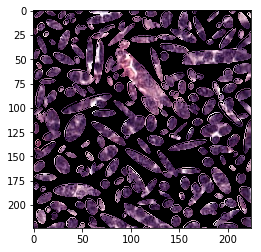

In [34]:
plt.imshow(before.astype('uint8'))

In [35]:
# Apply mask on original image
mask_im = closing(mask_im)

hematoxylin_im = np.copy(tumor_tile)
eosin_im = np.copy(tumor_tile)

hematoxylin_im[~(mask_im.astype(bool))] = 0
eosin_im[mask_im.astype(bool)] = 0

show_images([hematoxylin_im, eosin_im], ['Hematoxylin', 'Eosin'])

NameError: name 'mask_im' is not defined

In [36]:
# Create ternary image
class_im = (np.ones((224,224,3)) * 255).astype(np.uint8)
class_im[~(mask_im.astype(bool)[:,:,0])] = (255,163,221)
class_im[mask_im.astype(bool)[:,:,0]] = (15,15,225)
plt.imshow(class_im)

NameError: name 'mask_im' is not defined